In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import CLB.CLBXMLWriter as CLBXML   
import tempfile
import scipy.optimize as so
from display_xml import XML
import sympy

# Notes on LBM dt in nonlinear reactions

### d2q9_reaction_diffusion_system_SIR_ModifiedPeng

or the WSIR model, aleready referenced in this workshop

$$
\frac{\partial}{\partial t} W = \beta_W \left[\frac{r^2}{8}W + (I-W) \right] \\
\frac{\partial}{\partial t} S = - \beta \frac{S}{N}W\\
\frac{\partial}{\partial t} I = \beta \frac{S}{N}W - \gamma I \\
\frac{\partial}{\partial t} R = \gamma I
$$



$ t = \tilde{t}*\delta t $

$$
\frac{\partial}{\partial \tilde{t}} W = \frac{\beta_W}{\delta t} \left[\frac{r^2}{8}W + (I-W) \right] \\
\frac{\partial}{\partial \tilde{t}} S = - \frac{\beta}{\delta t}\frac{S}{N}W\\
\frac{\partial}{\partial \tilde{t}} I = \frac{\beta}{\delta t} \frac{S}{N}W - \gamma I \\
\frac{\partial}{\partial \tilde{t}} R = \frac{\gamma}{\delta t} I
$$

In [2]:
import sys
sys.path.append("..")
from utils.sir_plot_utils import *

def WSIR_1D_FD(S, I, R, nx, dx, r0, beta_sir, gamma_sir, nt, dt, beta_W=1e2):
    W = I.copy()
    N = S + I + R
    c_ind = np.arange(0, nx)
    l_ind = np.roll(c_ind, -1)
    r_ind = np.roll(c_ind, 1)

    for n in range(nt):  # iterate through time
        lap_W = (W[l_ind] - 2 * W[c_ind] + W[r_ind]) / dx ** 2
        qW_spatial = (r0 * r0 / 8.)*lap_W
        # qW_spatial = np.zeros(nx)

        qW = dt * beta_W * (qW_spatial + (I - W))
        qS2I = dt * beta_sir * S * W/N
        qI2R = dt * gamma_sir * I

        W = W + qW
        S = S - qS2I
        I = I + qS2I - qI2R
        R = R + qI2R
        
    return S, I, R, W

## We could use build-in IVP solvers for such prepared stencil

In [3]:
from scipy.integrate import solve_ivp

nx = 128
domain_length = 64
dx = domain_length / (nx-1)
xspace = np.linspace(0, domain_length, nx)

# r0 = 5.5  # infectious radius
# beta_sir = 3.01  # the average number of contacts per person per time
# gamma_sir = 1/2.8  # 1 over days to recovery
# beta_W = 1e3

r0 = 5.5  # infectious radius
gamma_sir = 0.25  # 1 over days to recovery
beta_sir = 3.01 * 2.8 * gamma_sir
t_scale = 1 #gamma_sir / (1./2.8)
beta_W = 1e3 / t_scale




total_time = 1e-0
dt = 1e-5
ntimesteps = int(total_time / dt)
N = np.ones(nx) 
N[int((nx-1)/4):int(nx/2 + 1)] *= 10

I_IC = 0.05* np.ones(nx)
I_IC[int(3*(nx-1)/8):int(6*nx/8 + 1)] *= 10 

S_IC = N - I_IC
R_IC = np.zeros(nx)

y_lim  = [-0.05, 1.05*max(N)]


c_ind = np.arange(0, nx)
l_ind = np.roll(c_ind, -1)
r_ind = np.roll(c_ind, 1)


def WSIR_1D_FD_VRK(t, z, nx, dx, r0, beta_sir, gamma_sir, beta_W):

    tmp = z.reshape((4,int(z.shape[0]/4)))
    
    W = tmp[0,:]
    S = tmp[1,:]
    I = tmp[2,:]
    R = tmp[3,:]
    
    lap_W = (W[l_ind] - 2 * W[c_ind] + W[r_ind]) / dx ** 2
    qW_spatial = (r0 * r0 / 8.)*lap_W

    qW =  beta_W * (qW_spatial + (I - W))
    qS2I =  beta_sir * S * W/N
    qI2R =  gamma_sir * I
       
    return np.array([qW, - qS2I, qS2I - qI2R, qI2R]).reshape((4*nx))





IC = np.array([I_IC, S_IC, I_IC, R_IC]).reshape((4*nx))

days_to_simulate = 1
sol = solve_ivp(WSIR_1D_FD_VRK,
                [0, days_to_simulate],
                IC,
                method='RK45',
                args=[nx, dx, r0, beta_sir, gamma_sir, beta_W],
                dense_output=True)

t = np.linspace(0, days_to_simulate, 21)
z = sol.sol(t)



In [4]:
tmp = z.reshape((4, int(z.shape[0]/4), len(t)))
W_rk45 = tmp[0,:,:]
S_rk45 = tmp[1,:,:]
I_rk45 = tmp[2,:,:]
R_rk45 = tmp[3,:,:]


# Explicit Euler and RK45 solutions are close-to-identical

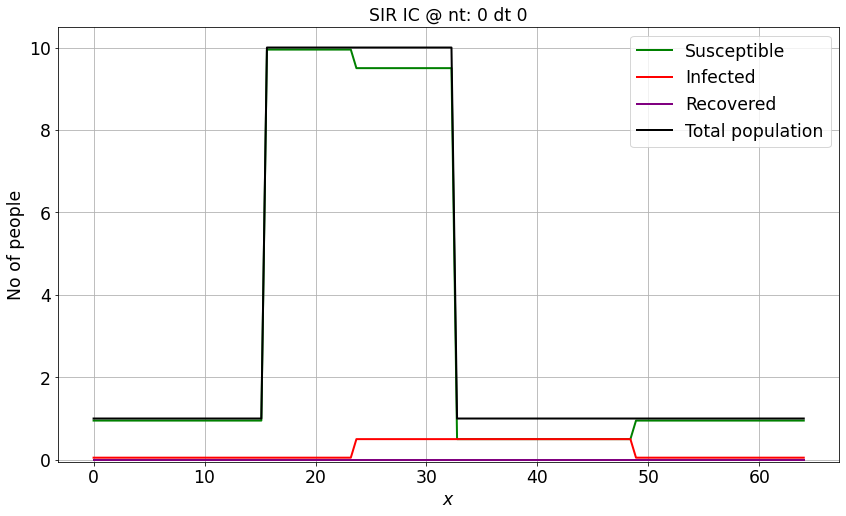

In [5]:
from utils.sir_plot_utils import make_wsir_plot_1D
make_wsir_plot_1D(S_IC, I_IC, R_IC, xspace, 0, 0, 'SIR IC', w=None, y_lim=y_lim)



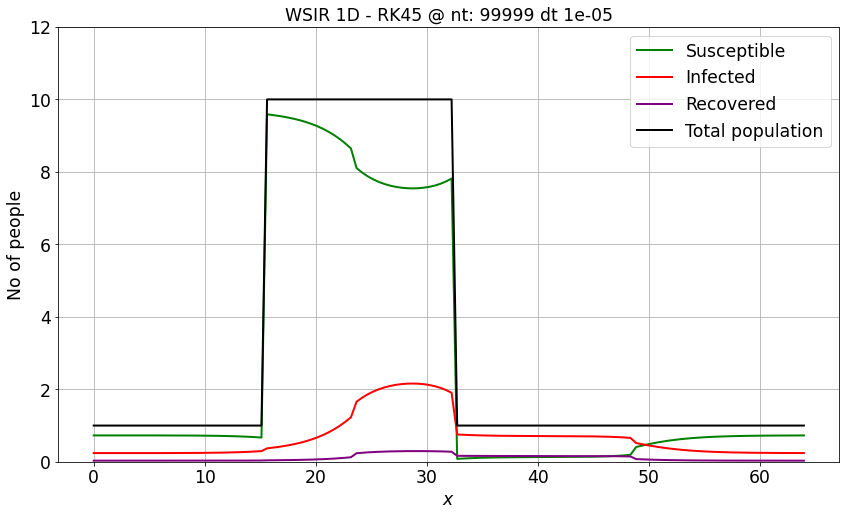

In [6]:
Sw, Iw, Rw, Ww = WSIR_1D_FD(S_IC, I_IC, R_IC, nx, dx, r0, beta_sir, gamma_sir, ntimesteps, dt, beta_W)
make_wsir_plot_1D(Sw, Iw, Rw, xspace, ntimesteps, dt, 'WSIR 1D - RK45',  y_lim=(0,12))

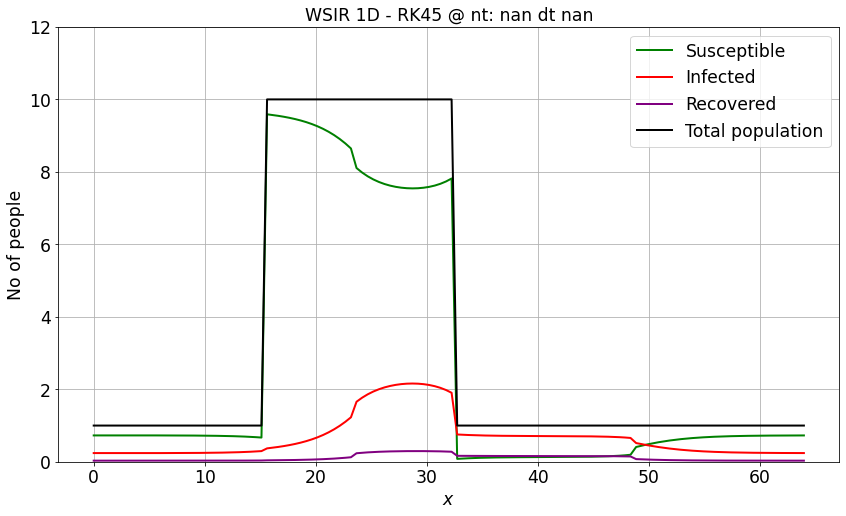

In [7]:
make_wsir_plot_1D(S_rk45[:,-1], I_rk45[:,-1], R_rk45[:,-1], xspace, np.nan, np.nan, 'WSIR 1D - RK45',  y_lim=(0,12))

# Let's build LBM solution using TCLB and _d2q9_reaction_diffusion_system_SIR_ModifiedPeng_ model

There is gonna be units change: LBM has "dt" equall 1, while we obsiously need some small dt in _real_ units - for example expressed as a fraction of specific time $1/\gamma$. Please also be carefull at:
```python
1 / 1e-5
1 / (dt_LBM * 1e6) * 1e6
```

In [11]:
np.savetxt("S_IC.csv", S_IC, delimiter=",")
np.savetxt("I_IC.csv", I_IC, delimiter=",")
np.savetxt("R_IC.csv", R_IC, delimiter=",")


dt_LBM = 1.e-5

R_LBM = r0 / dx
Beta_LBM = beta_sir * dt_LBM
Beta_w_LBM = beta_W * dt_LBM
Gamma_LBM = gamma_sir * dt_LBM 


CLBc = CLBXML.CLBConfigWriter( )

CLBc.addGeomParam('nx', S_IC.shape[0])
CLBc.addGeomParam('ny', 2)


CLBc.addRunR(eval=\
"""
    init = read.table("S_IC.csv", header = FALSE, sep = "", dec = ".");
    Solver$Fields$Init_S_External[] = init[,1];
    
    init = read.table("I_IC.csv", header = FALSE, sep = "", dec = ".");
    Solver$Fields$Init_I_External[] = init[,1];
    Solver$Fields$Init_W_External[] = init[,1];


    init = read.table("R_IC.csv", header = FALSE, sep = "", dec = ".");
    Solver$Fields$Init_R_External[] = init[,1];

    # and N
    Solver$Fields$Init_N_External[] = Solver$Fields$Init_S_External[] + Solver$Fields$Init_I_External[] + Solver$Fields$Init_R_External[];


    Solver$Actions$InitFromExternalAction();
""")

    
params = {
        "Diffusivity_W": Beta_w_LBM * R_LBM**2 / 8.,
        "Init_W": 1,
        "Init_S": 0,
        "Init_I": 0,
        "Init_R": 1,
        "Init_N": 1,
        "Beta": Beta_LBM,
        "Beta_w": Beta_w_LBM,
        "Gamma": Gamma_LBM,
}

CLBc.addModelParams(params)

T = int( 1 / (dt_LBM * 1e6) * 1e6 )

CLBc.addHDF5()
solve = CLBc.addSolve(iterations=T)
CLBc.addHDF5(Iterations=int(T/10), parent=solve)
   
CLBc.write('WSIR_1DExample.xml')

f = open('WSIR_1DExample.xml', 'r')
XML(''.join(f.readlines()))



In [12]:
! OMP_NUM_THREADS=8 tclb d2q9_reaction_diffusion_system_SIR_ModifiedPeng WSIR_1DExample.xml   && echo 'DONE!'

MPMD: TCLB: local:0/1 work:0/1 ---  connected to:
[  ] -------------------------------------------------------------------------
[  ] -  CLB version:       v6.5.0-73-g4654a377                               -
[  ] -        Model: d2q9_reaction_diffusion_system_SIR_ModifiedPeng                 
[  ]               -
[  ] -------------------------------------------------------------------------
[  ] Setting output path to: WSIR_1DExample
[  ] Discarding 1 comments
[ 0] Running on CPU
[ 0] WARNING: No "Units" element in config file
[  ] Mesh size in config file: 128x2x1
[  ] Global lattice size: 128x2x1
[  ] Max region size: 256. Mesh size 256. Overhead:  0%
[  ] Local lattice size: 128x2x1
Hello allocator!
[  ]   Threads  |      Action
[  ]     1x1    | Primal , NoGlobals , InitFromExternal
[  ]     1x1    | Tangent , NoGlobals , InitFromExternal
[  ]     1x1    | Optimize , NoGlobals , InitFromExternal
[  ]     1x1    | SteadyAdjoint , NoGlobals , InitFromExternal
[  ]     1x1    | Primal

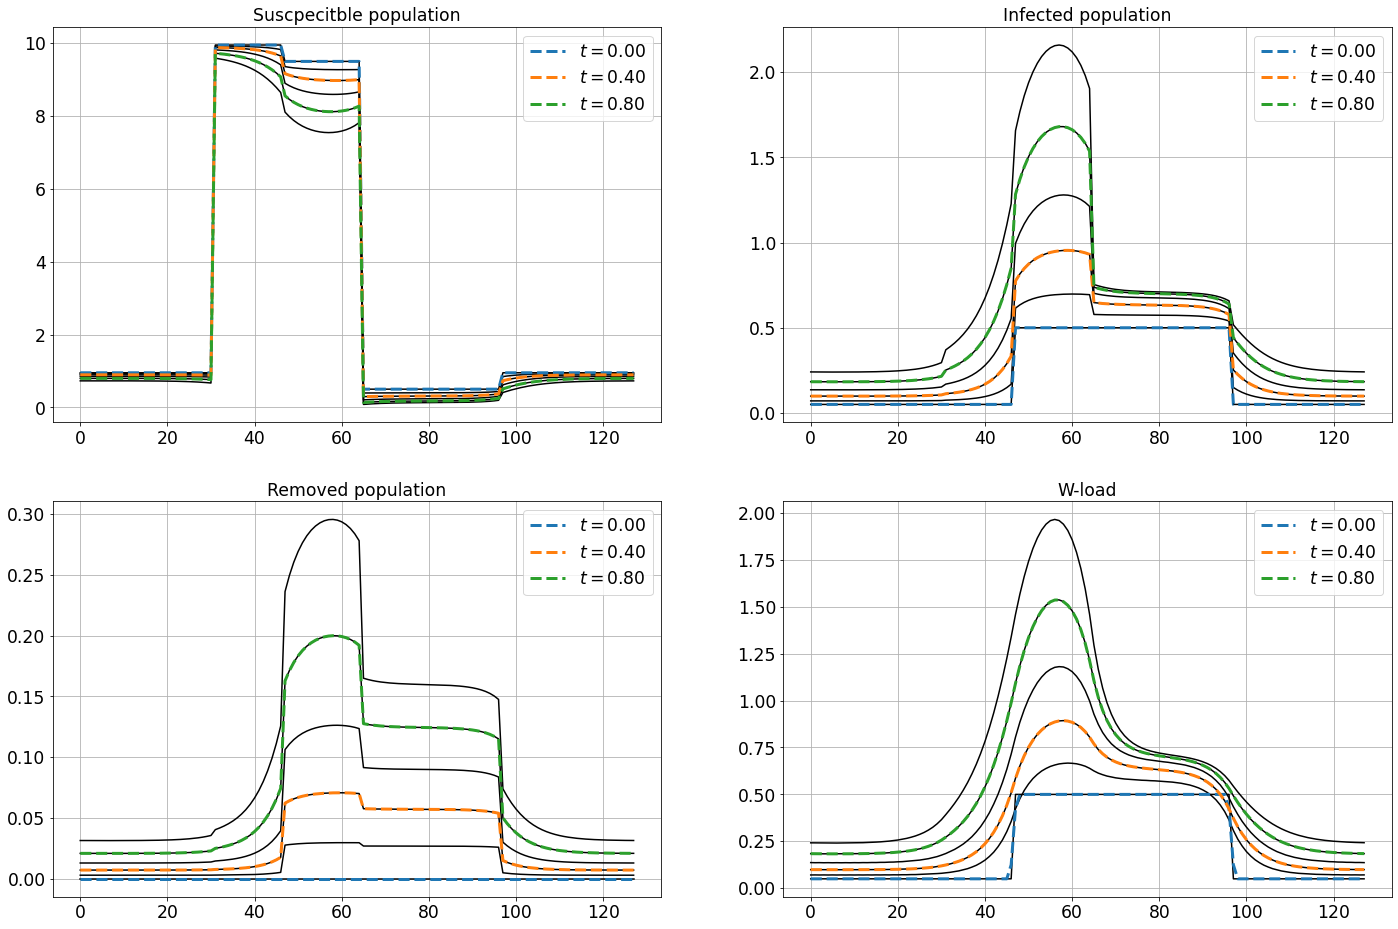

In [16]:
plt.figure(figsize=(24,16))
plt.subplot(221)
plt.title('Suscpecitble population')

plt.plot(S_rk45[:,::4], 'k-')

for i in np.arange(0,T,T/10)[::4]:
    f = h5py.File('./output/WSIR_1DExample_HDF5_%08d.h5'%i)    
    #plt.plot(f['ODE_1'][0,0,:], '--')
    #plt.plot(f['ODE_2'][0,0,:], '--')
    plt.plot(f['S'][0,0,:], '--', lw=3, label=r'$t=%.2f$'%(i*dt_LBM))         
    
plt.legend()
plt.grid(which='both')



plt.subplot(222)

plt.title('Infected population')

plt.plot(I_rk45[:,::4], 'k-')

for i in np.arange(0,T,T/10)[::4]:
    f = h5py.File('./output/run_HDF5_%08d.h5'%i)    
    #plt.plot(f['ODE_1'][0,0,:], '--')
    #plt.plot(f['ODE_2'][0,0,:], '--')
    plt.plot(f['I'][0,0,:], '--', lw=3, label=r'$t=%.2f$'%(i*dt_LBM))         
    
plt.legend()
plt.grid(which='both')



plt.subplot(223)

plt.title('Removed population')

plt.plot(R_rk45[:,::4], 'k-')

for i in np.arange(0,T,T/10)[::4]:
    f = h5py.File('./output/run_HDF5_%08d.h5'%i)    
    #plt.plot(f['ODE_1'][0,0,:], '--')
    #plt.plot(f['ODE_2'][0,0,:], '--')
    plt.plot(f['R'][0,0,:], '--', lw=3, label=r'$t=%.2f$'%(i*dt_LBM))         
    
plt.legend()
plt.grid(which='both')


plt.subplot(224)

plt.title('W-load')

plt.plot(W_rk45[:,::4], 'k-')

for i in np.arange(0,T,T/10)[::4]:
    f = h5py.File('./output/run_HDF5_%08d.h5'%i)    
    #plt.plot(f['ODE_1'][0,0,:], '--')
    #plt.plot(f['ODE_2'][0,0,:], '--')
    plt.plot(f['W'][0,0,:], '--', lw=3, label=r'$t=%.2f$'%(i*dt_LBM))         
    
plt.legend()
plt.grid(which='both')

# We could also compare evolution of SIR variables at point in space

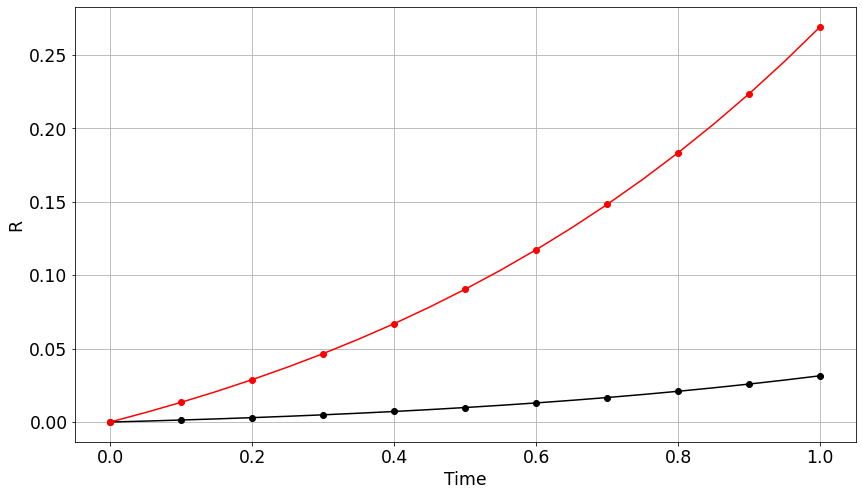

In [17]:
#make_wsir_plot_1D(Sw, Iw, Rw, xspace, ntimesteps, dt, 'WSIR 1D',  y_lim=(0,12))

#plt.plot(Sw, '-')
#plt.plot(Iw, '-')
#plt.plot(t, S_rk45[0,:], '-')
#plt.plot(t, I_rk45[0,:], '-')
plt.plot(t,R_rk45[0,:], 'k-')
plt.plot(t,R_rk45[50,:], 'r-')


#plt.plot(S)
#plt.plot(I)
#plt.plot(R, 'o-')
#plt.plot(W)
j = 0
for i in np.array(t/(dt_LBM*1e6)*1e6, dtype=int)[::2]:
    f = h5py.File('./output/run_HDF5_%08d.h5'%i)    
    plt.plot(i*dt_LBM, f['R'][0,0,0], 'ko')         
    plt.plot(i*dt_LBM, f['R'][0,0,50], 'ro')         
    
plt.xlabel('Time')
plt.ylabel('R')
plt.grid(which='both')

# Read "wall" map into TCLB

In [18]:
from skimage import data, filters, color, morphology
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.segmentation import flood, flood_fill

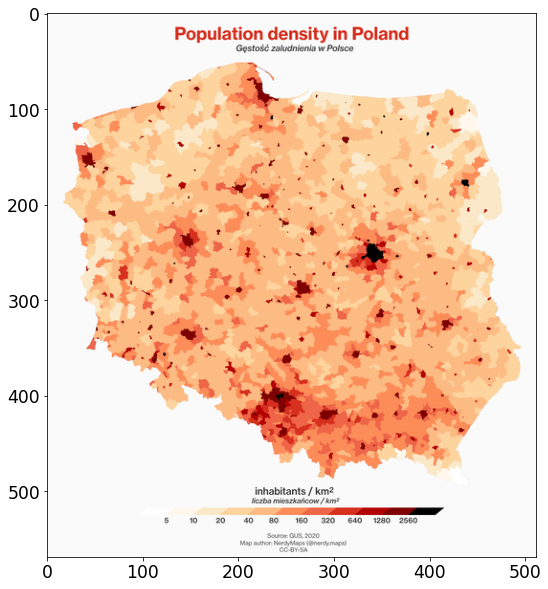

In [19]:
from PIL import Image
import requests
from io import BytesIO


#url = 'https://upload.wikimedia.org/wikipedia/commons/f/fc/Poland_wordmark2.png'
#response = requests.get(url)
#img = Image.open(BytesIO(response.content))
img_org = np.array(Image.open('512px-Population_density_in_Poland.png'))
plt.figure(figsize=(10,10))
plt.imshow(img_org)

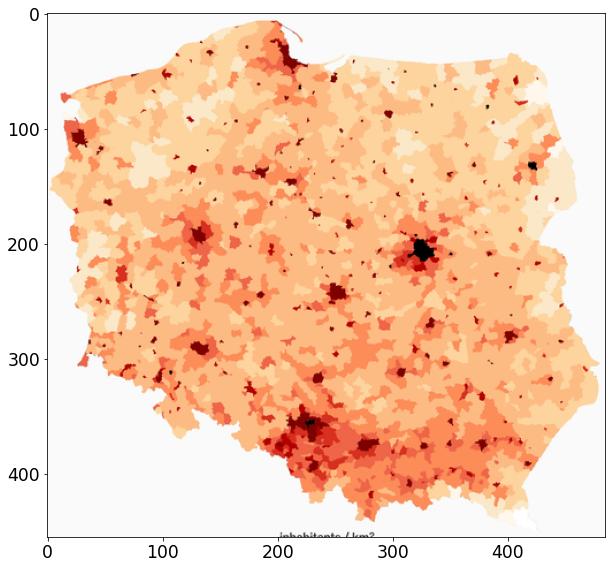

In [20]:
plt.figure(figsize=(10,10))
img = img_org[45:500,15:500,:]
plt.imshow(img)

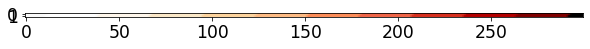

In [21]:
plt.figure(figsize=(10,10))

legend = img_org[520:522,90:390,:]
plt.imshow(legend)

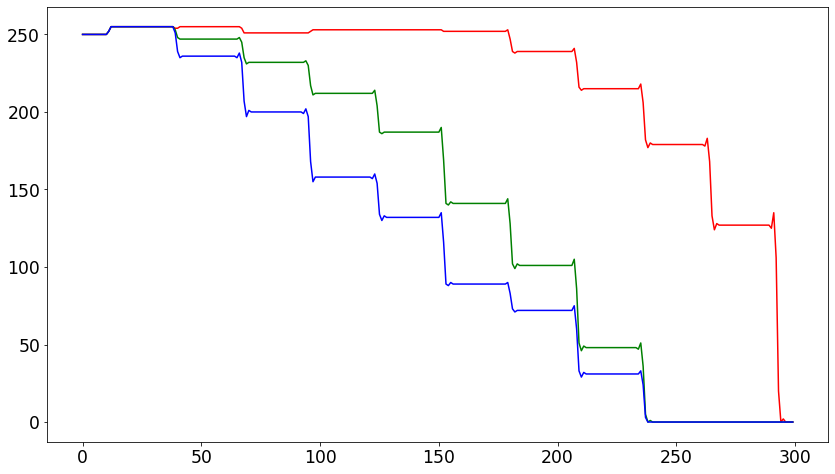

In [22]:
plt.plot(legend[0,:,0],'r')
plt.plot(legend[0,:,1],'g')
plt.plot(legend[0,:,2], 'b')

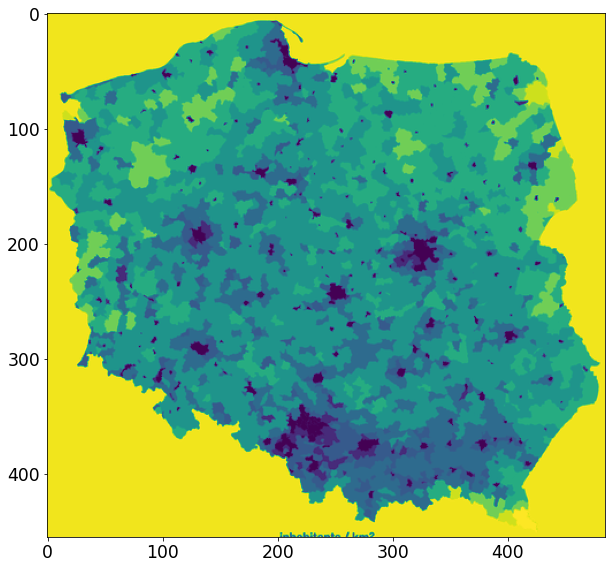

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(img[:,:,2])

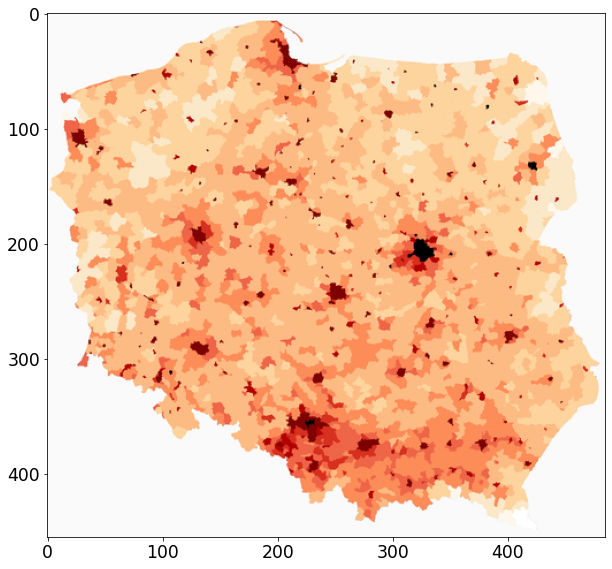

In [24]:
plt.figure(figsize=(10,10))
img[445:,:300,:] = img[0,0,:]
plt.imshow(img)

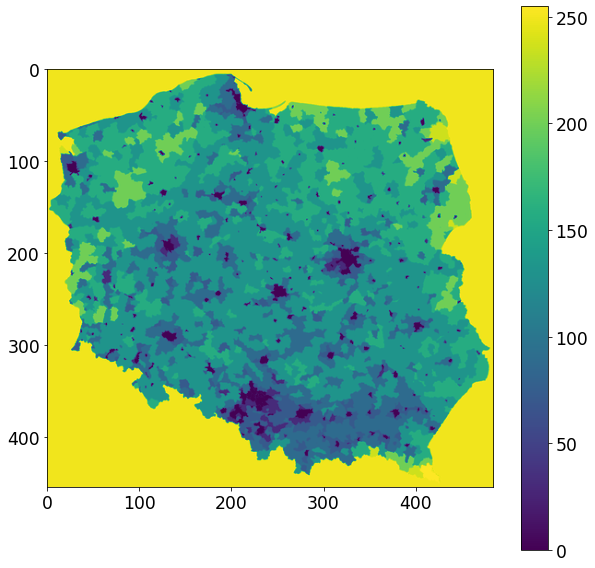

In [25]:
plt.figure(figsize=(10,10))

country_map_zero = np.copy(img) 
#country_map[ (img[:,:,2] == img[0,0,2]) * (img[:,:,1] == img[0,0,1]) ] = -1
country_map_zero = country_map_zero[:,:,2]
#

plt.imshow(country_map_zero[:,:])
plt.colorbar()

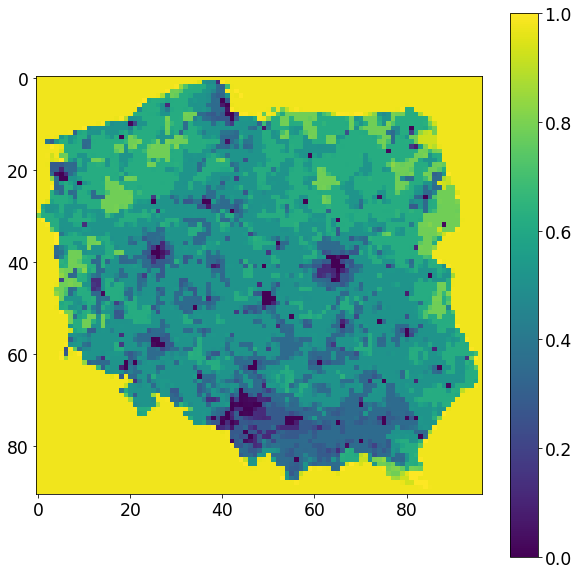

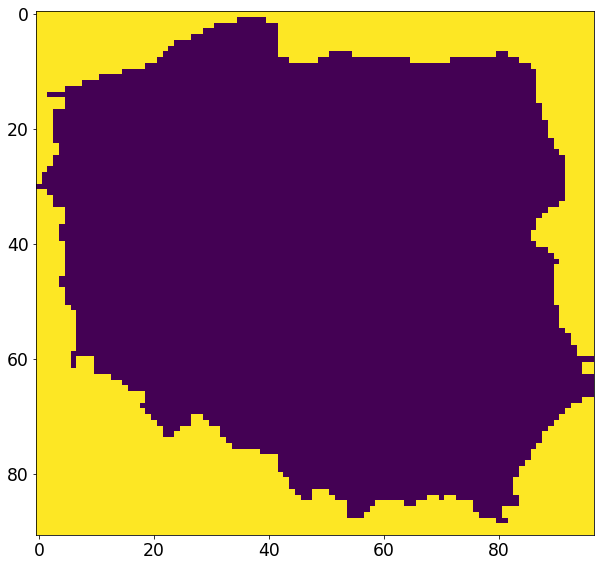

In [26]:
country_map = rescale(country_map_zero, 0.2,anti_aliasing=False)

plt.figure(figsize=(10,10))

plt.imshow(country_map)
plt.colorbar()
country_map_binary = flood_fill(country_map >= 245./255., (1,1), 1) 


country_map_binary = morphology.binary_opening(country_map_binary, np.ones((2,2)))
plt.figure(figsize=(10,10))

plt.imshow(country_map_binary)


In [27]:
np.savetxt('input.txt',country_map_binary.T, fmt="%d")

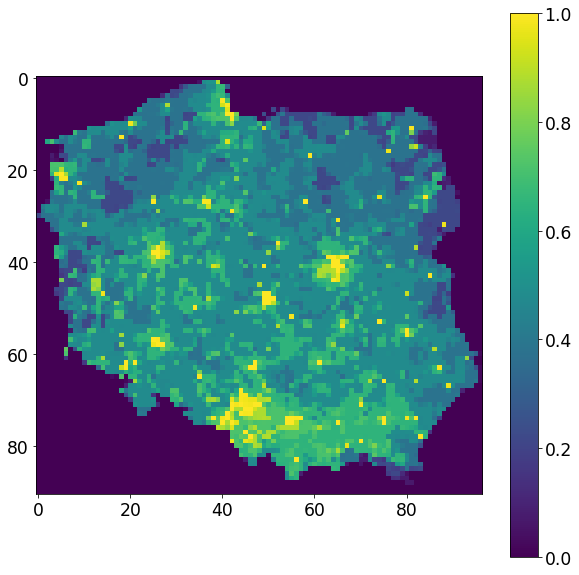

In [30]:
density_map = 1-np.array(country_map, dtype=float)
density_map[country_map_binary==1] = 0
plt.figure(figsize=(10,10))
plt.imshow(density_map)
plt.colorbar()

In [31]:
init_binfile = open('init.bin', 'wb')
init_binfile.write(density_map)
init_binfile.close()

# We will use TCLB to blurr image a little, while obeying BC

MPMD: TCLB: local:0/1 work:0/1 ---  connected to:
[  ] -------------------------------------------------------------------------
[  ] -  CLB version:       v6.5.0-73-g4654a377                               -
[  ] -        Model: d2q9_reaction_diffusion_system_SimpleDiffusion                  
[  ]              -
[  ] -------------------------------------------------------------------------
[  ] Setting output path to: run-blurr
[  ] Discarding 1 comments
[ 0] Running on CPU
[ 0] WARNING: No "Units" element in config file
[  ] Mesh size in config file: 97x91x1
[  ] Global lattice size: 97x91x1
[  ] Max region size: 8827. Mesh size 8827. Overhead:  0%
[  ] Local lattice size: 97x91x1
Hello allocator!
[  ]   Threads  |      Action
[  ]     1x1    | Primal , NoGlobals , InitFromExternal
[  ]     1x1    | Tangent , NoGlobals , InitFromExternal
[  ]     1x1    | Optimize , NoGlobals , InitFromExternal
[  ]     1x1    | SteadyAdjoint , NoGlobals , InitFromExternal
[  ]     1x1    | Primal , I

<Figure size 1008x576 with 0 Axes>

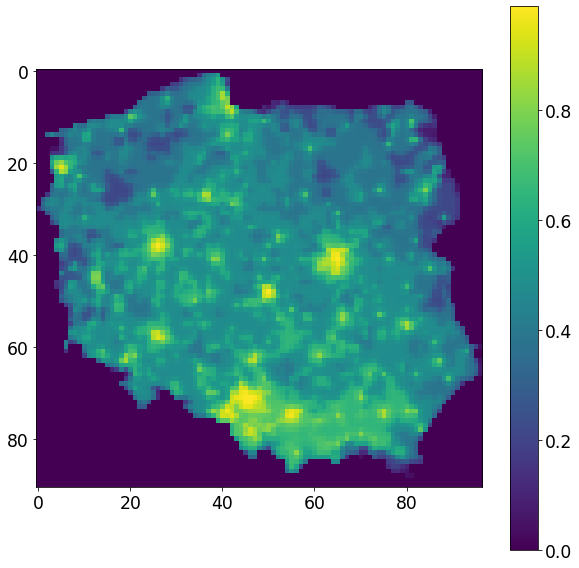

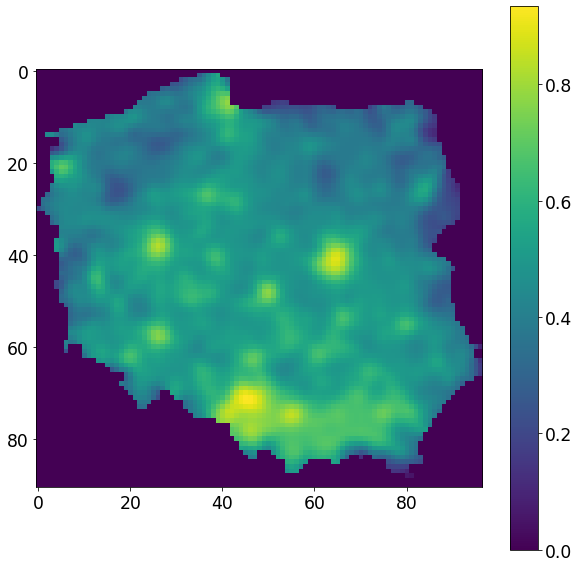

<Figure size 1008x576 with 0 Axes>

In [34]:
CLBc = CLBXML.CLBConfigWriter( )

CLBc.addGeomParam('nx', country_map_binary.shape[1])
CLBc.addGeomParam('ny', country_map_binary.shape[0])

CLBc.addWall(name='foreign')
CLBc.addText(file='input.txt')


params = {
        "Diffusivity_PHI" : 1./6.,
        "Init_PHI":0.0,
}


dim = country_map_binary.shape
CLBc.addModelParams(params)

params = {
        "Diffusivity_PHI" : 1./6.,
        "Init_PHI":0.0,
}

CLBc.addModelParams(params, zone='foreign')


CLBc.addRunR(eval=\
 f"""
     infile <- "init.bin"
     con <- file(infile, "rb")
     pic <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]})), {dim[1]},{dim[0]})
     
     close(con)
     Solver$Fields$Init_PHI_External[] = pic;

    
    
     Solver$Actions$InitFromExternalAction();
 """)

CLBc.addHDF5()
T=5
solve = CLBc.addSolve(iterations=T)
CLBc.addHDF5()
   
CLBc.write('run-blurr.xml')

! tclb d2q9_reaction_diffusion_system_SimpleDiffusion run-blurr.xml&& echo "DONE"

plt.figure(figsize=(10,10))
i = 0
f = h5py.File('./output/run-blurr_HDF5_%08d.h5'%i)    
plt.imshow(f['PHI'][0,:,:])
plt.colorbar()


plt.figure(figsize=(10,10))
i = T
f = h5py.File('./output/run-blurr_HDF5_%08d.h5'%i)    
plt.imshow(f['PHI'][0,:,:])
plt.colorbar()
plt.figure()


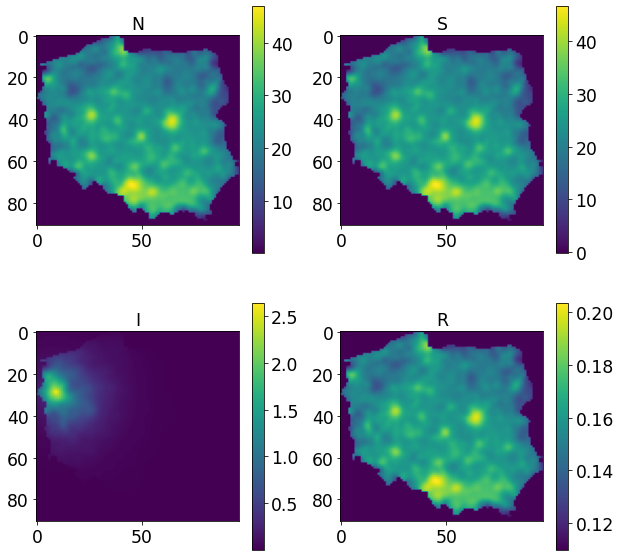

In [36]:
i = T
f = h5py.File('./output/run-blurr_HDF5_%08d.h5'%i)    

blured = np.copy(f['PHI'][0,:,:]) + 0.1
N0 = 50
X0=0.1*blured.shape[0]
Y0=0.3*blured.shape[1]
r_sick = 0.1*blured.shape[1]

X,Y = np.meshgrid(np.arange(blured.shape[1]), np.arange(blured.shape[0]))

R = np.sqrt((X-X0)**2+(Y-Y0)**2)

#init_binfile = open('init-blured.bin', 'wb')
#init_binfile.write()
#init_binfile.close()
I0_map = blured*np.exp(-R/r_sick)*N0*0.1
R0_map = blured*0.1 + 0.1
S0_map = (blured-0.1)*N0 - I0_map

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('N')
plt.imshow(S0_map+I0_map+R0_map)
plt.colorbar()

plt.subplot(222)
plt.title('S')
plt.imshow(S0_map)
plt.colorbar()

plt.subplot(223)
plt.title('I')
plt.imshow(I0_map)
plt.colorbar()


plt.subplot(224)
plt.title('R')
plt.imshow(R0_map)
plt.colorbar()




init_binfile = open('init-map-S.bin', 'wb')
init_binfile.write(S0_map)
init_binfile.close()


init_binfile = open('init-map-I.bin', 'wb')
init_binfile.write(I0_map)
init_binfile.close()


init_binfile = open('init-map-R.bin', 'wb')
init_binfile.write(R0_map)
init_binfile.close()


init_binfile = open('init-map-N.bin', 'wb')
init_binfile.write(S0_map+R0_map+I0_map)
init_binfile.close()

In [53]:

dt_LBM = 1.e-4

R_LBM = np.sqrt(8./6./Beta_w_LBM) 

Beta_LBM = beta_sir * dt_LBM 
Beta_w_LBM = beta_W * dt_LBM 
Gamma_LBM = gamma_sir * dt_LBM  



CLBc = CLBXML.CLBConfigWriter( )

CLBc.addGeomParam('nx', country_map_binary.shape[1])
CLBc.addGeomParam('ny', country_map_binary.shape[0])

CLBc.addWall(name='foreign')
CLBc.addText(file='input.txt')

dim = country_map_binary.shape

CLBc.addRunR(eval=\
f"""

    con <- file("init-map-S.bin", "rb")
    init <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]})), {dim[1]},{dim[0]})
    close(con)
    Solver$Fields$Init_S_External[] = init;
    

    con <- file("init-map-I.bin", "rb")
    init <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]})), {dim[1]},{dim[0]})
    close(con)
    Solver$Fields$Init_I_External[] = init;
    Solver$Fields$Init_W_External[] = init;


    con <- file("init-map-R.bin", "rb")
    init <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]})), {dim[1]},{dim[0]})
    close(con)
    Solver$Fields$Init_R_External[] = init;

    # and N
    Solver$Fields$Init_N_External[] = Solver$Fields$Init_S_External[] + Solver$Fields$Init_I_External[] + Solver$Fields$Init_R_External[];


    Solver$Actions$InitFromExternalAction();
""")

    
params = {
        "Diffusivity_W": Beta_w_LBM * R_LBM**2 / 8.,
        "Init_W": 1,    
        "Init_S": 1,
        "Init_I": 1,
        "Init_R": 1,
        "Init_N": 3,
        "Beta": Beta_LBM,
        "Beta_w": Beta_w_LBM,
        "Gamma": Gamma_LBM,
}

CLBc.addModelParams(params)

T = int( 10 / (dt_LBM * 1e6) * 1e6 )
#T = 100000

CLBc.addHDF5()
solve = CLBc.addSolve(iterations=T, 
                      failcheck_dx=dim[0]/2, 
                      failcheck_dy=dim[1]/2,
                      failcheck_nx=10, 
                      failcheck_ny=10,
                      failcheck=int(T/60), 
                      failcheck_fields='DRE_1'
)
CLBc.addHDF5(Iterations=int(T/30), parent=solve)
   
    
CLBc.write('WSIR_CountryMap.xml')

f = open('WSIR_CountryMap.xml', 'r')
print(''.join(f.readlines()))
! tclb d2q9_reaction_diffusion_system_SIR_ModifiedPeng WSIR_CountryMap.xml && echo "DONE"


<CLBConfig version="2.0" output="output/">
  <!--Created using CLBConfigWriter-->
  <Geometry predef="none" model="MRT" nx="97.0000000000000000" ny="91.0000000000000000">
    <Wall name="foreign" mask="ALL">
      <Text file="input.txt"/>
    </Wall>
  </Geometry>
  <Model>
    <Param name="Diffusivity_W" value="0.1666666666666667"/>
    <Param name="Init_W" value="1.0000000000000000"/>
    <Param name="Init_S" value="1.0000000000000000"/>
    <Param name="Init_I" value="1.0000000000000000"/>
    <Param name="Init_R" value="1.0000000000000000"/>
    <Param name="Init_N" value="3.0000000000000000"/>
    <Param name="Beta" value="0.0002107000000000"/>
    <Param name="Beta_w" value="0.1000000000000000"/>
    <Param name="Gamma" value="0.0000250000000000"/>
  </Model>
  <RunR><![CDATA[

    con <- file("init-map-S.bin", "rb")
    init <- matrix( readBin(con, "numeric", prod(8827)), 97,91)
    close(con)
    Solver$Fields$Init_S_External[] = init;
    

    con <- file("init-map-I.bin", "r

0
33330
66660
99990
0
33330
66660
99990
0
33330
66660
99990
0
33330
66660
99990


<Figure size 720x720 with 0 Axes>

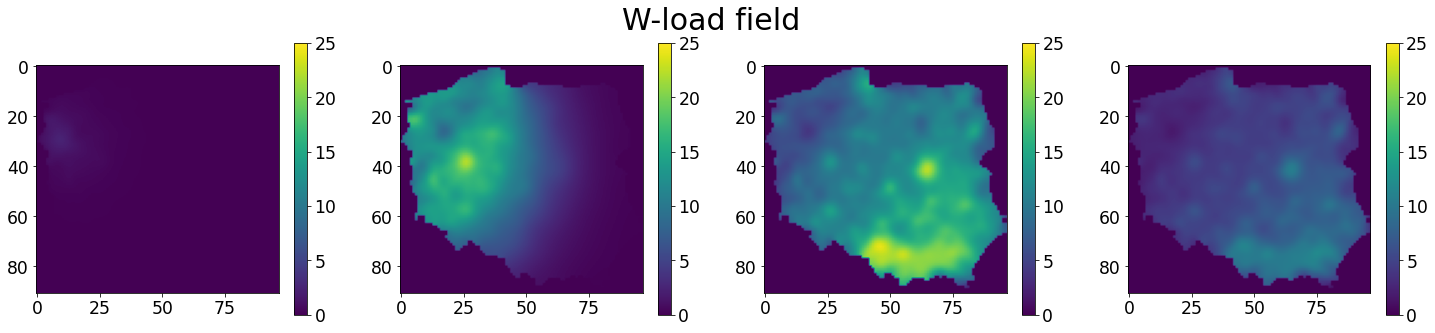

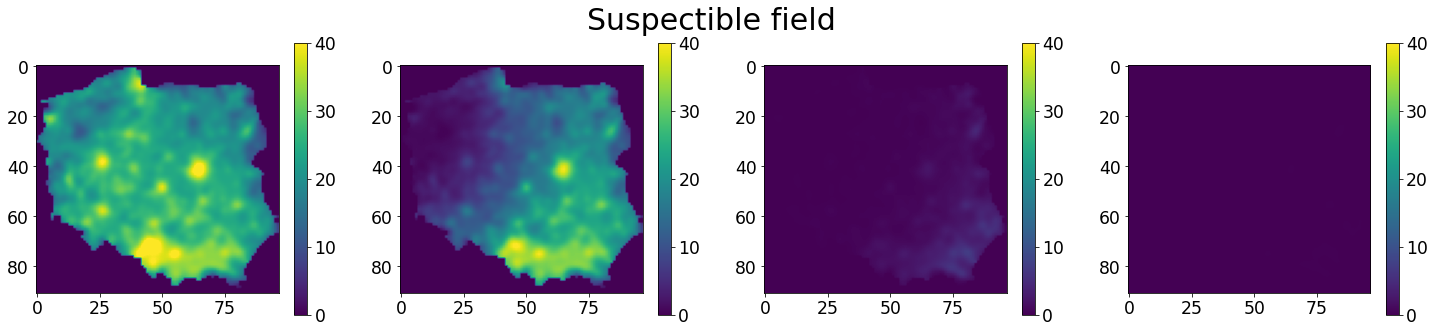

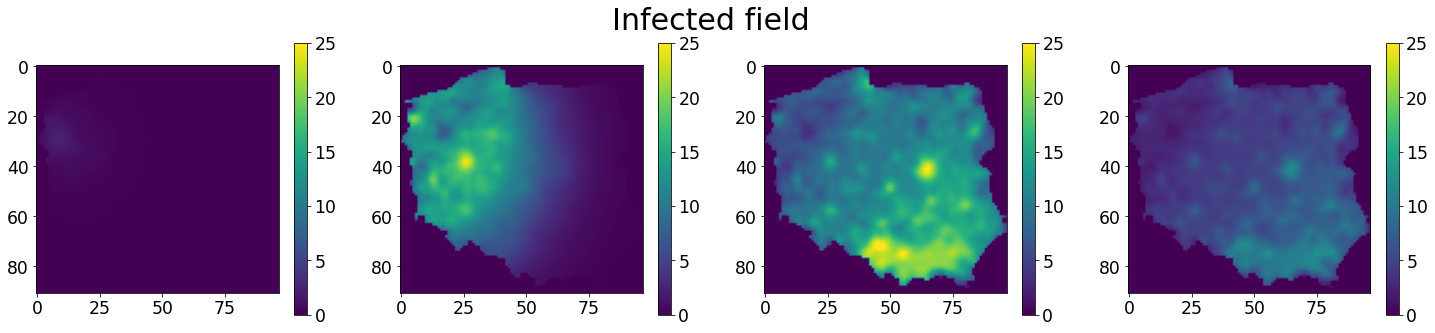

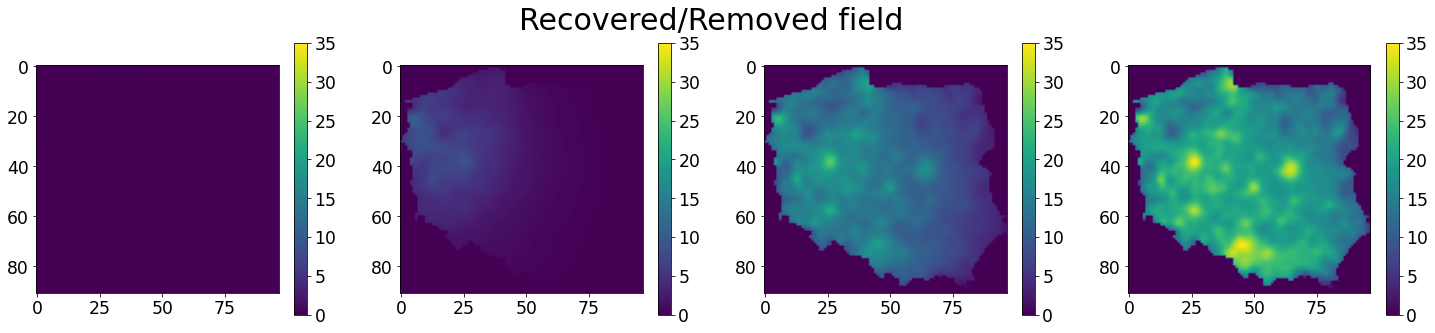

In [63]:
plt.figure(figsize=(10,10))

cases = np.arange(0,T,int(T/30.))[::10]

init = dict()

for name, field,lim in [('W-load field', 'W',7),('Suspectible field', 'S',40),('Infected field', 'I',7),('Recovered/Removed field', 'R',2)]:
    i = 0
    f = h5py.File('./output/WSIR_CountryMap_HDF5_%08d.h5'%i)    
    init[field] = f[str(field)][0,:,:]
    
        
for name, field,lim in [('W-load field', 'W',25),('Suspectible field', 'S',40),('Infected field', 'I',25),('Recovered/Removed field', 'R',35)]:
    plt.figure(figsize=(25,5))
    plt.suptitle(name, fontsize=30)

    for num, i in enumerate(cases):
        print(i)
        f = h5py.File('./output/WSIR_CountryMap_HDF5_%08d.h5'%i)    
        plt.subplot(len(cases)*10+100+num+1)
        plt.imshow(f[field][0,:,:])
        plt.clim(0,lim)
        plt.colorbar()

#     plt.subplot(152)
#     plt.title('S')
#     plt.imshow(f['ODE_1'][0,:,:])
#     plt.colorbar()

#     plt.subplot(153)
#     plt.title('I')
#     plt.imshow(f['ODE_2'][0,:,:])
#     plt.colorbar()


#     plt.subplot(154)
#     plt.title('R')
#     plt.imshow(f['ODE_3'][0,:,:])
#     plt.colorbar()

#     plt.subplot(155)
#     plt.title('R')
#     plt.imshow(f['ODE_1'][0,:,:]+f['ODE_2'][0,:,:]+f['ODE_3'][0,:,:])
#     plt.colorbar()

Text(0, 0.5, '# of people')

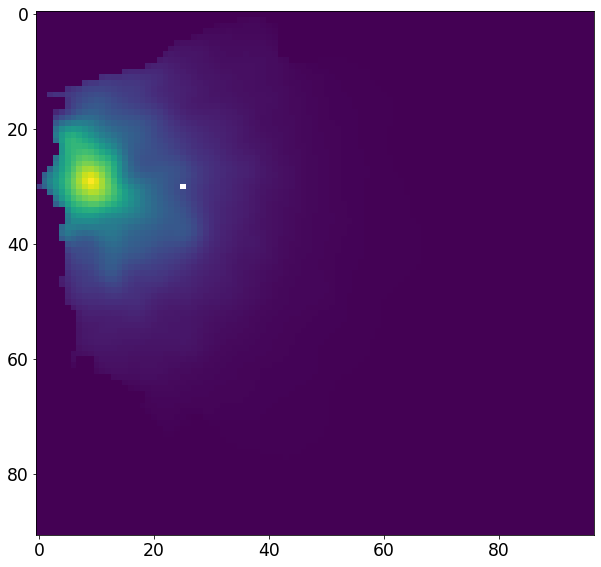

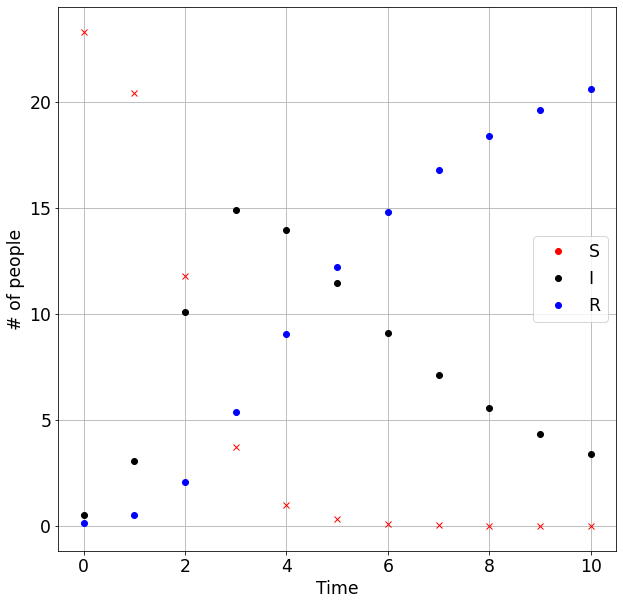

In [60]:
plt.figure(figsize=(10,10))
xx = 30
yy = 25
i = 0
f = h5py.File('./output/WSIR_CountryMap_HDF5_%08d.h5'%i)    

tmp = f['W'][0,:,:]
tmp[xx,yy] = np.nan
plt.imshow(tmp)


plt.figure(figsize=(10,10))
for i in np.arange(0,T,int(T/30.))[::3]:
    f = h5py.File('./output/WSIR_CountryMap_HDF5_%08d.h5'%i)    
    plt.plot(i*dt_LBM,f['S'][0,xx,yy], 'rx')    
    plt.plot(i*dt_LBM,f['I'][0,xx,yy], 'ko')
    plt.plot(i*dt_LBM,f['R'][0,xx,yy], 'bo')
# plt.ylabel('# of people')
# plt.twinx()
# for i in np.arange(0,T,int(T/30.)):
#     f = h5py.File('./output/run_HDF5_%08d.h5'%i)    

#     plt.plot(i*dt_LBM,f['ODE_1'][0,xx,yy], 'ro')

    
plt.plot(np.nan, 'ro', label='S')
plt.plot(np.nan, 'ko', label='I')
plt.plot(np.nan, 'bo', label='R')
plt.legend()
plt.grid(which='both')
plt.xlabel('Time')
plt.ylabel('# of people')

# Modified SIR model by Peng 

or the WSIR model, aleready referenced in this workshop

$$
\frac{\partial}{\partial t} W = \beta_W \left[\frac{r^2}{8}W + (I-W) \right] \\
\frac{\partial}{\partial t} S = - \beta \frac{S}{N}W\\
\frac{\partial}{\partial t} I = \beta \frac{S}{N}W - \gamma I \\
\frac{\partial}{\partial t} R = \gamma I
$$



### d2q9_reaction_diffusion_system_SIR_ModifiedPeng

$$
S = ODE_1 \\
I = ODE_2 \\
R = ODE_3 \\
C_1 = R_0 \\
C_2 = \beta
C_3 = dt
$$


### Simple XML example


```xml

<?xml version="1.0"?>
<CLBConfig version="2.0" output='output/'>
	<Geometry nx="100" ny="100">

		<None name="city">
			<Box dx="45" dy="45" nx="10" ny="10"/>
		</None> 

	</Geometry>
	<Model>
		<Param name="Diffusivity_DRE_1" value="0.1666"/>


		<Param name="C_1" value="5"/>  <!-- R0 -->
		<Param name="C_2" value="2"/>  <!-- Beta -->
		<Param name="C_3" value="0.001"/>  <!-- dt -->
		

		

        
		<!-- Init_DRE_1 and Init_ODE_2 should start the same -->
		<Param name="Init_DRE_1" value="0." />	 <!-- W -->

		<Param name="Init_ODE_1" value="0.9" />	<!-- S -->		
		<Param name="Init_ODE_2" value="0." />	 <!-- I -->
		<Param name="Init_ODE_3" value="0.1"/>	<!-- R -->



		
        <!-- Those should start the same -->
		<Param name="Init_DRE_1" value="0.1" zone="city"/>	 <!-- W -->
		<Param name="Init_ODE_2" value="0.1" zone="city"/>	 <!-- I -->

		<Param name="Init_ODE_1" value="0.9" zone="city"/>	<!-- S -->

    </Model>

	<HDF5/>
    <Solve Iterations="10000">
	<HDF5 Iterations="100"/>
	</Solve> 
    
</CLBConfig>


```

In [271]:
! tclb d2q9_reaction_diffusion_system_SIR_ModifiedPeng ./d2q9_diffusion_SIR_PengModified.xml > /dev/null && echo "DONE"

Hello allocator!
DONE


/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.8/dist-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


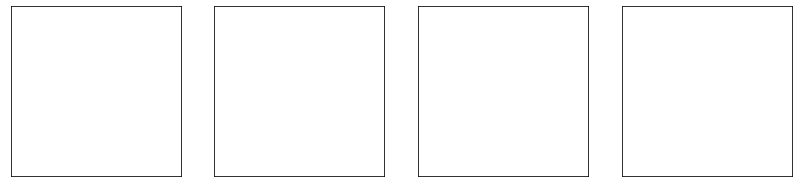

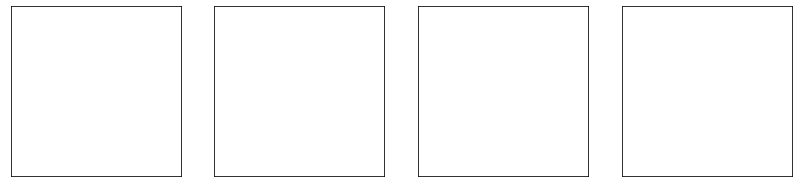

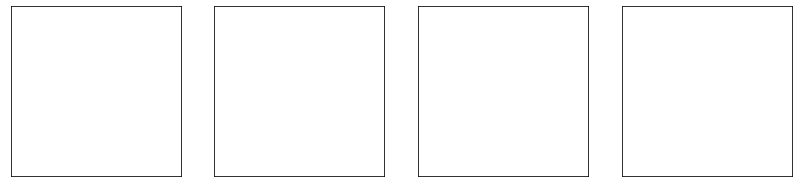

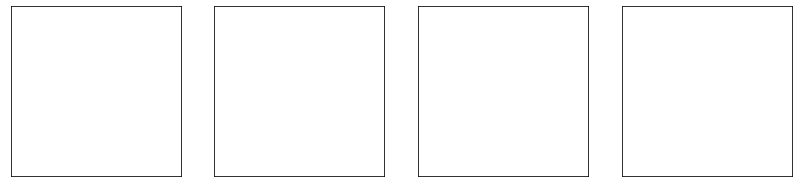

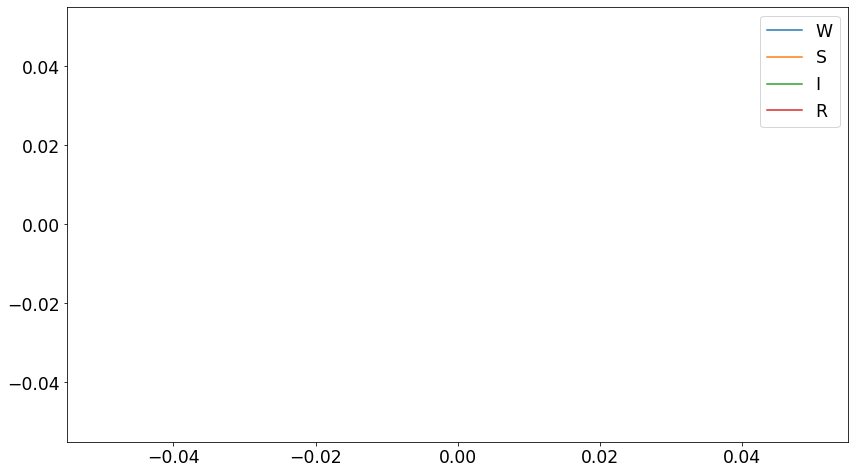

In [272]:
S = list()
I = list()
R = list()
W = list()
n0 = 30
n = 0
for i in range(100,10000,100):
    f = h5py.File('./output/d2q9_diffusion_SIR_PengModified_HDF5_%08d.h5'%i)    
    #print(f['ODE_1'][:,:,:])
    S.append( np.sum(f['ODE_1'][:,:,:]) )
    I.append( np.sum(f['ODE_2'][:,:,:]) )
    R.append( np.sum(f['ODE_3'][:,:,:]) )
    
    W.append(  np.sum(f['DRE_1'][:,:,:]) )
    n -= 1
    if n <= 0:
        n = n0
        plt.figure()
        pop = np.zeros_like(f['ODE_1'][0,:,:])
        for figi, fnam in enumerate([f'ODE_{k}' for k in range(1,4)]):
            plt.subplot(1,4,figi+1)
            if i == 0:
                plt.title(['S', 'I', 'R'][figi])
            plt.imshow(f[fnam][0,:,:])
            pop = pop + f[fnam][0,:,:]
            plt.clim(0,1)
            plt.xticks([])
            plt.yticks([])
            #plt.plot(f[fnam][0,50,:])
        plt.subplot(1,4,4)
            
        plt.imshow(pop)
        
        plt.xticks([])
        plt.yticks([])        

plt.figure()
     
plt.plot(W, '-', label='W')
plt.plot(S, '-', label='S')
plt.plot(I, '-', label='I')
plt.plot(R, '-', label='R')
plt.legend()


# Let's embed it all in function call

### TODO
#### Zadanie F - Benchmark II: Poprawność symulacji równań typu SIR w domenie z niejednorodnym rozmieszczeniem populacji
 - Nie brakuje $ 1/P$ ? gdzie P =S + I +R (czyli gęstość zaludnienia)
 - opisać interpretacje parametru cos dW/dt =cos r^2 /8 laplasjan W --> raport/ szkolenie .md

#### Jupyter notebook z przykładem WSIR FD vs LBM
(najpierw GG musi skonczyc WSIR FD - #26 )